# Does Aya store factual knowledge neutrally? Using Multilingual LAMA dataset

**Description**:
* Does Aya store factual knowledge neutrally across languages?
* Method: Compare factual responses across languages.
* Evaluation: Answer consistency, embedding similarity.
* Input: Fact-based questions in multiple languages.
* Output: Degree of variation in factual accuracy across languages.
* Expected Insight: If factual consistency varies by language, Aya may encode knowledge in a language-dependent manner.

This notebook `.ipynb` aims to do analysis on the `results/mlama_factual_knowledge_results` result from the `experiments/factual_knowledge_experiment` experiment.

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
result_df = pd.read_csv("../results/mlama_factual_knowledge_results.csv")

In [62]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   language          10400 non-null  object
 1   fact_id           10800 non-null  object
 2   subject           10800 non-null  object
 3   relation          10800 non-null  object
 4   question          10800 non-null  object
 5   options           10800 non-null  object
 6   golden_answer     10800 non-null  object
 7   predicted_answer  10800 non-null  object
 8   is_correct        10800 non-null  bool  
dtypes: bool(1), object(8)
memory usage: 685.7+ KB


In [63]:
print(f"Loaded {len(result_df)} rows.")
result_df.head()

Loaded 10800 rows.


,language,fact_id,subject,relation,question,options,golden_answer,predicted_answer,is_correct
0,afr,Q191954_P1001_Q142,President van Frankryk,P1001,President van Frankryk is 'n wettige term in _...,"['Nigerië', 'Italië', 'Jamaika', 'Frankryk']",Frankryk,Frankryk,True
1,afr,Q839078_P1001_Q16,Kategorie:Eerste Ministers van Kanada,P1001,Kategorie:Eerste Ministers van Kanada is 'n we...,"['Kanada', 'Guyana', 'Indonesië', 'Bolivië']",Kanada,Kanada,True
2,afr,Q5176750_P1001_Q155,President van Brasilië,P1001,President van Brasilië is 'n wettige term in _...,"['Libië', 'Japan', 'Skotland', 'Brasilië']",Brasilië,Brasilië,True
3,afr,Q319145_P1001_Q408,Eerste Minister van Australië,P1001,Eerste Minister van Australië is 'n wettige te...,"['Kuba', 'Viëtnam', 'Australië', 'Turkye']",Australië,Australië,True
4,afr,Q475689_P1001_Q16,Parlement van Kanada,P1001,Parlement van Kanada is 'n wettige term in _____.,"['Bolivië', 'Kanada', 'Nigerië', 'Haïti']",Kanada,Kanada,True


In [64]:
# Group by language and calculate mean accuracy
lang_accuracy = result_df.groupby("language")["is_correct"].mean().reset_index()

# Sort by accuracy
lang_accuracy = lang_accuracy.sort_values(by="is_correct", ascending=False)

print(f"Computed accuracy for {len(lang_accuracy)} languages.")
print(lang_accuracy)

Computed accuracy for 52 languages.
   language  is_correct
33      msa       0.975
20      heb       0.975
51      zho       0.960
0       afr       0.900
13      est       0.895
3       bel       0.890
8       cym       0.850
50      vie       0.790
2       aze       0.775
30      lat       0.725
35      pol       0.725
7       ces       0.720
37      ron       0.720
31      lav       0.720
39      slk       0.720
36      por       0.715
49      urd       0.715
47      tur       0.710
42      sqi       0.710
22      hrv       0.695
41      spa       0.680
19      glg       0.675
26      ita       0.675
24      hye       0.660
10      deu       0.650
25      ind       0.645
9       dan       0.645
14      eus       0.635
44      swe       0.630
40      slv       0.625
34      nld       0.625
12      eng       0.610
17      fra       0.595
6       cat       0.595
32      lit       0.580
23      hun       0.580
16      fin       0.570
18      gle       0.540
45      tam       0.535
38  

C:\Users\Muhammad Ravi SH\AppData\Local\Temp\ipykernel_16688\3447485003.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lang_accuracy, x="language", y="is_correct", palette="viridis")


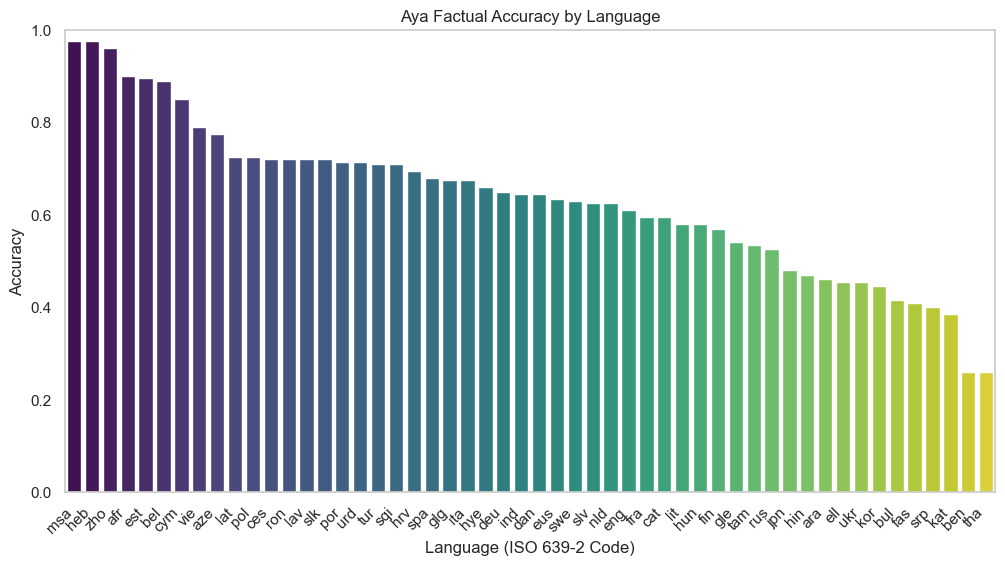

In [65]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=lang_accuracy, x="language", y="is_correct", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Aya Factual Accuracy by Language")
plt.xlabel("Language (ISO 639-2 Code)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Aya performs very accurately in some languages like Malay, Hebrew, and Chinese but struggles significantly in languages like Thai, Bengali, and Georgian.  
This indicates **language-dependent variation** in factual accuracy, suggesting that some languages are better "supported" or better "aligned" than others within the model's knowledge.

In [66]:
## see only the fact_id "/m/010cf_place_of_death_/m/01q0l"
fact_id_dummy = result_df[result_df["fact_id"] == "/m/010cf_place_of_death_/m/01q0l"]
fact_id_dummy

,language,fact_id,subject,relation,question,options,golden_answer,predicted_answer,is_correct
4956,hrv,/m/010cf_place_of_death_/m/01q0l,Abdul Medžid I.,place_of_death,Abdul Medžid I. umro u _____.,"['Amsterdam', 'Toronto', 'Carigrad', 'Napulj']",Carigrad,Carigrad,True
5253,hye,/m/010cf_place_of_death_/m/01q0l,Աբդուլ Մեջիդ,place_of_death,Աբդուլ Մեջիդ մահացավ _____ -ում:,"['Յոկոհամա', 'Մադրիդ', 'Կոստանդնուպոլիս', 'Քին...",Կոստանդնուպոլիս,Կոստանդնուպոլիս,True
5595,ind,/m/010cf_place_of_death_/m/01q0l,Abd-ul-Mejid I,place_of_death,Abd-ul-Mejid I meninggal di _____.,"['Hollywood', 'Amsterdam', 'Konstantinopel', '...",Konstantinopel,Konstantinopel,True
6871,lav,/m/010cf_place_of_death_/m/01q0l,Abdulmedžids I,place_of_death,Abdulmedžids I nomira _____.,"['Lietuva', 'Boloņa', 'Manhetena', 'Konstantin...",Konstantinopole,Konstantinopole,True
8387,slk,/m/010cf_place_of_death_/m/01q0l,Abdülmecid I.,place_of_death,Abdülmecid I. zomrel v _____.,"['Konštantínopol', 'Detroit', 'Madrid', 'Lipsko']",Konštantínopol,Konštantínopol,True
10490,vie,/m/010cf_place_of_death_/m/01q0l,Abdül Mecid I,place_of_death,Abdül Mecid I chết trong _____.,"['Toronto', 'Nice', 'Manhattan', 'Constantinop...",Constantinopolis,Constantinopolis,True


In [67]:
# Group by fact_id
fact_groups = result_df.groupby("fact_id")

consistency_list = []

for fact_id, group in fact_groups:
    answers = group["predicted_answer"]
    correct = (group["predicted_answer"] == group["golden_answer"]).sum()
    accuracy = correct / len(group)
    if len(answers) > 1:
        # Count the most common answer
        most_common_answer = answers.mode()[0]
        consistency = (answers == most_common_answer).sum() / len(answers)
        consistency_list.append({
            "fact_id": fact_id,
            "consistency": consistency,
            "accuracy": accuracy,
            "n_languages": len(answers)
        })

consistency_df = pd.DataFrame(consistency_list)
print(f"Computed consistency for {len(consistency_df)} facts.")
consistency_df.head()

Computed consistency for 1329 facts.


,fact_id,consistency,accuracy,n_languages
0,/m/010cf_place_of_death_/m/01q0l,0.166667,1.000000,6
1,/m/0127f2_place_of_birth_/m/06c62,0.500000,0.916667,12
2,/m/019z_6_place_of_death_/m/0cl8c,0.500000,0.500000,2
3,/m/01cv72_place_of_birth_/m/09bkv,0.500000,0.500000,2
4,/m/01f5sj_place_of_birth_/m/04jpl,0.500000,0.000000,2


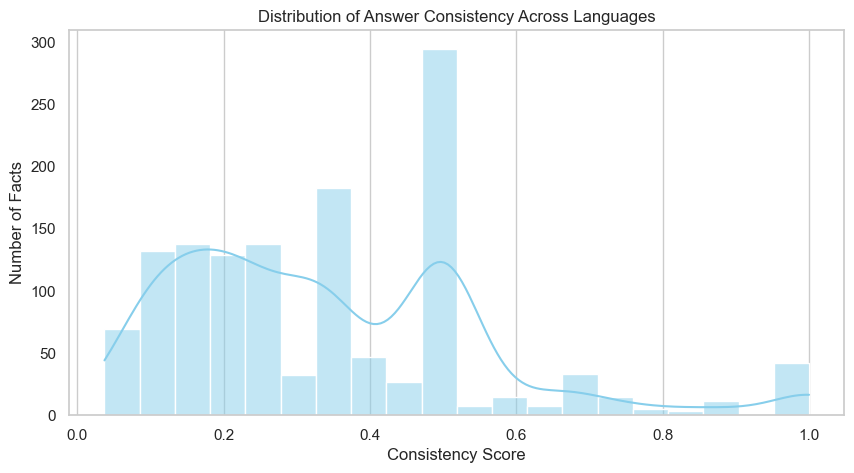

In [68]:
plt.figure(figsize=(10, 5))
sns.histplot(consistency_df["consistency"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Answer Consistency Across Languages")
plt.xlabel("Consistency Score")
plt.ylabel("Number of Facts")
plt.grid(axis='y')
plt.show()

In [69]:
# Summary Statistics (Consistency + Accuracy)
consistency_summary = {
    "Average Consistency": np.mean(consistency_df["consistency"]),
    "Median Consistency": np.median(consistency_df["consistency"]),
    "Percentage of Perfectly Consistent Facts": (consistency_df["consistency"] == 1.0).mean() * 100,
    "Average Accuracy": np.mean(consistency_df["accuracy"]),
    "Median Accuracy": np.median(consistency_df["accuracy"]),
    "Percentage of Fully Correct Facts": (consistency_df["accuracy"] == 1.0).mean() * 100
}

print("Summary of Consistency and Accuracy Metrics:")
for key, value in consistency_summary.items():
    print(f"{key}: {value:.3f}")

Summary of Consistency and Accuracy Metrics:
Average Consistency: 0.345
Median Consistency: 0.333
Percentage of Perfectly Consistent Facts: 3.160
Average Accuracy: 0.667
Median Accuracy: 0.750
Percentage of Fully Correct Facts: 30.399


The average and median consistency scores being around **34%** indicate that for many facts, **Aya provides different answers across languages most of the time**. Only a small fraction (\~3.2%) of facts are perfectly consistent across all evaluated languages.

However, the relatively high **average accuracy (67%)** and **median accuracy (75%)** suggest that **Aya often answers correctly in individual languages**, even if the answers are not always the same across them. This highlights that **Aya retrieves factual knowledge in a noticeably language-dependent manner**, with accuracy maintained but consistency lacking.

In [70]:
unknown_rate = (result_df["predicted_answer"] == "UNKNOWN").mean()
print(f"Rate of UNKNOWN answers: {unknown_rate:.2%}")

Rate of UNKNOWN answers: 0.26%


A very small proportion (<0.3%) of answers were `"UNKNOWN"`, which means the model almost always attempted an answer and did not skip or default excessively. Thus, variations in responses are due to real **answer differences**, not model refusal.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cosine
import cohere

# Initialize Cohere client
co = cohere.Client("YOUR_COHERE_API_KEY")  # Replace with your actual API key

# Load the previous evaluation results
result_df = pd.read_csv("../results/mlama_factual_knowledge_results.csv")

# Display a sample of the data
print(f"Loaded {len(result_df)} rows.")
result_df.head()

# Compute embeddings for each predicted answer using Cohere embed-multilingual-v3.0 model
print("Computing embeddings...")

batch_size = 100  # Cohere API handles batch requests efficiently
embeddings = []

for i in tqdm(range(0, len(result_df), batch_size)):
    batch_texts = result_df['predicted_answer'].iloc[i:i+batch_size].astype(str).tolist()
    response = co.embed(
        texts=batch_texts,
        model="embed-multilingual-v3.0",
        input_type="classification"  # appropriate for short answers
    )
    embeddings.extend(response.embeddings)

# Add embeddings to the dataframe
result_df['embedding'] = embeddings

print("Embedding computation completed.")

# Group by fact_id
fact_groups = result_df.groupby("fact_id")

# List to store similarity results
fact_similarity_records = []

for fact_id, group in tqdm(fact_groups, desc="Computing similarity per fact"):
    embeddings = group["embedding"].tolist()
    n = len(embeddings)
    
    # Skip if there is only one language
    if n <= 1:
        continue
    
    # Calculate pairwise cosine similarities
    similarities = []
    for i in range(n):
        for j in range(i + 1, n):
            sim = 1 - cosine(embeddings[i], embeddings[j])
            similarities.append(sim)
    
    # Compute average similarity for the fact
    avg_similarity = np.mean(similarities) if similarities else None
    
    fact_similarity_records.append({
        "fact_id": fact_id,
        "n_languages": n,
        "avg_similarity": avg_similarity
    })

# Convert the similarity records into a DataFrame
similarity_df = pd.DataFrame(fact_similarity_records)
similarity_df.head()

# Summary statistics
avg_sim = similarity_df['avg_similarity'].mean()
median_sim = similarity_df['avg_similarity'].median()
high_sim_rate = (similarity_df['avg_similarity'] > 0.8).mean()

print(f"Average Embedding Similarity: {avg_sim:.3f}")
print(f"Median Embedding Similarity: {median_sim:.3f}")
print(f"Percentage of facts with similarity > 0.8: {high_sim_rate:.2%}")

Loaded 10800 rows.
Computing embeddings...


100%|██████████| 108/108 [01:56<00:00,  1.08s/it]


Embedding computation completed.


Computing similarity per fact: 100%|██████████| 2151/2151 [00:04<00:00, 519.34it/s] 

Average Embedding Similarity: 0.674
Median Embedding Similarity: 0.664
Percentage of facts with similarity > 0.8: 19.56%


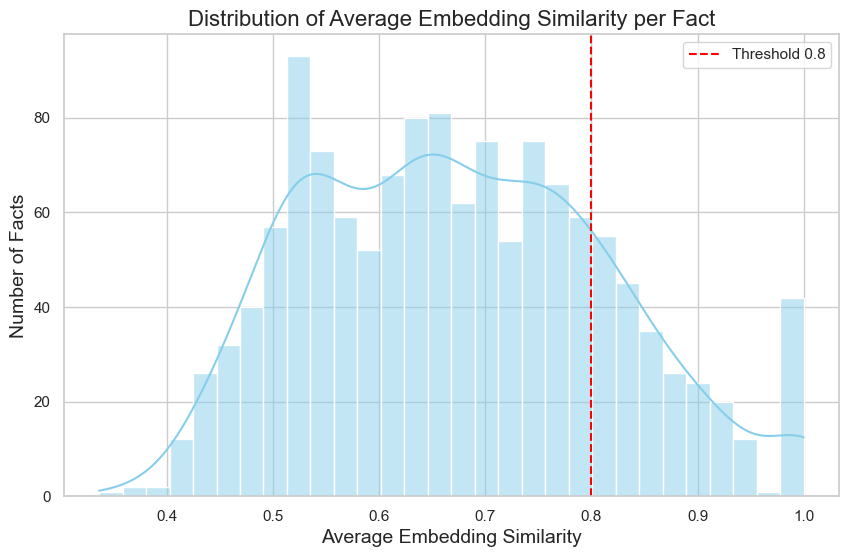

In [72]:
# Set style
sns.set(style="whitegrid")

# Plot histogram of average embedding similarities
plt.figure(figsize=(10,6))
sns.histplot(similarity_df['avg_similarity'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Embedding Similarity per Fact', fontsize=16)
plt.xlabel('Average Embedding Similarity', fontsize=14)
plt.ylabel('Number of Facts', fontsize=14)
plt.axvline(x=0.8, color='red', linestyle='--', label='Threshold 0.8')
plt.legend()
plt.show()

While Aya often provides semantically similar factual answers across languages, the average embedding similarity (\~0.67) indicates that **semantic consistency is present but not strong**.
Only around **20% of facts reach high semantic similarity** (>0.8), suggesting that:

* There is **moderate but imperfect alignment in factual meaning** across languages.
* Some factual responses may reflect **language-specific framing or variation**.

Combined with the lower answer consistency, this implies that **Aya encodes factual knowledge in a way that is not fully language-neutral**, with meaningful cross-lingual variation present in both form and meaning.

# ✨ **Summary Conclusion**

* Aya exhibits **strong factual capabilities** in some languages, but its performance is **weaker in others**, with **lower accuracy** and **higher variability in answers** across languages.
* Factual answers are **not fully neutral across languages**, with significant **variation in consistency** and **accuracy** observed between languages.
* The language of the question **influences Aya’s factual responses**, suggesting that some knowledge is **partially encoded in a language-dependent manner**.
* Cross-lingual **semantic similarity** of answers is **moderate**, with an average embedding similarity of **0.674**.
* Only **19.56%** of facts exhibit **high semantic similarity** (>0.8), indicating that **semantic drift** is **relatively common** across languages.
* **Factual consistency** across languages is relatively **low**, with only **3.16%** of facts being perfectly consistent across languages.
* **Accuracy** of factual answers across languages shows variation, with an overall **average accuracy** of **66.7%**, indicating **inconsistent correctness** across languages.

### 🎯 Main Question Answer:

**Does Aya store factual knowledge neutrally?**

❌ **No, Aya does not store factual knowledge in a fully language-neutral way.**

Factual consistency **varies significantly** across languages, indicating that Aya’s internal knowledge representation is **partially influenced by the language** of the input.

Only about **3.16%** of facts were perfectly consistent across languages (i.e., same answer in all), and the overall consistency rate is just **34.5%**.

**Accuracy** across languages is also variable, with an **average accuracy of 66.7%** and a **median of 75%**, suggesting that factual answers may not always be fully correct or consistent across languages.

Additionally, semantic similarity between answers (embedding-based) averages **0.674**, with only about **19.56%** of facts achieving high similarity (>0.8). This shows that **perfect neutrality is not achieved** even at the semantic level.